# **1. Clean Dataset**

From Google coarse discourse dataset and Reddit API, find comments and its corresponding discourse type. 

There are two files saved. One is with preprocess and without preprocess.

In [0]:
# Reddit API
!pip install praw

     |████████████████████████████████| 143kB 2.7MB/s 
     |████████████████████████████████| 204kB 8.4MB/s 


**1.1 function to clean posts**

In [0]:
# Preprocess the dataset
import re
import nltk
nltk.download('stopwords')  # Download text data sets, including stop words
nltk.download('punkt')
from nltk.corpus import stopwords

def clean_posts(post):
    # remove urls
    # print(type(post))
    text = re.sub(r'(https|http)?:\/\/.*[\r\n]*', '', post)
    # lower cases
    text = text.lower() # lowercase text
    # remove some symbols that is useless for indentify text
    # text = re.sub(r"[/(){}\[\]\|@,;''\*\-\#&$%^_]", ' ', text)
    # some symbols may be helpful for identify discourse, like question mark, Exclamation mark
    text = re.sub( r'([^a-zA-Z])', r' ', text)
    # remove digits
    text = re.sub(r'[0-9]+', '', text)
    # split text into a words vector
    words = text.split()
    # # remove stop words
    # stops = set(stopwords.words("english"))
    # meaningful_words = [w for w in words if w not in stops]
    # tokenize the word and some punctuation
    # words = nltk.word_tokenize(' '.join(meaningful_words))
    
    return words

# print(posts_to_words("4/7/13  \n\n7/27/12  \n\nhttp://www.imdb.com/title/tt0073440/reference\n\nIt was only a few minutes into Robert Altman's homespun epic *Nashville* that I got the feeling I was watching a great movie. By the end it could not be denied. Now I'm sure it helps that I'm a musician, since this created an immediate connection to the subject matter. I spent a portion of the movie with my Telecaster in my lap trying to play along with the characters who all seem to be really playing and singing these songs. However I also am *not* a fan of country western, so that could have easily been a turn off.  \n\nTo begin describing the action in the film is daunting. I can't even process a lot of what I saw. This movie is extremely dense, and the first 30 minutes or so are spent just trying to figure out who people are. Their relationships to one another - some of which are purely incidental - slowly become clear as things progress. It's an ensemble cast with no clear lead and lots of overlapping conversations. Some developments all tie together in the end. Some seem to be kind of loose ends. There is throughout, however, a very keen sense about people. These naturalistic performances are believable and so is the world they inhabit. It feels like a film that doesn't exaggerate - rather, it downplays some of the outrageousness which just makes it seem all the more outrageous. Consider for example Shelley Duvall's wig or Jeff Goldblum's entire character.  \n\nI feel I should mention this. Jeff Goldblum is in this film. He never speaks, and he is awesome.  \n\n*Nashville* is a musical. There is reportedly around an hour of music in its 150+ minute run time. I believe it. Sometimes these songs, most if not all of which are original, seem to speak pointedly to or about a character. Sometimes it's all about the shifts and glances in the audience. There are many memorable scenes, such as when a fragile country starlet spaces out on stage and begins rambling between numbers, or a disenchanted housewife waits at the back of a bar for a womanizing folk singer, or a poor deceived waitress is goaded into a striptease by a raucous crowd and still refuses to believe that she can't actually sing.   \n\nThis is rich film, a complex tapestry perfectly suited to a moment in time (the US Bicentennial) that seems as though it will reward additional viewings. I sometimes become fidgety during long movies but I was never bored with *Nashville*. It swept me along with its quirky and interesting characters to a climax that maybe I should have seen coming.  \n\n8/10"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**1.2 load reddit api and coarse dataset to find comment and its corresponding discourse type**

In [0]:
# Process the dataset and save in csv files
import json
import praw
import csv
import time
"""
    Dataset used: https://github.com/google-research-datasets/coarse-discourse/blob/master/coarse_discourse_dataset.json
    Reference: https://github.com/google-research-datasets/coarse-discourse
               Amy X. Zhang, Bryan Culbertson, Praveen Paritosh. Characterizing Online Discussion Using Coarse Discourse Sequences. In Proceedings of the International AAAI Conference on Weblogs and Social Media (ICWSM '17). Montreal, Canada. 2017.
    API used: praw Reddit

    Clean up the the dataset, which contains the annotations of discourse, and use the reddit API to find the corresponding text.
"""

reddit = praw.Reddit(user_agent='jerry',
                     client_id='ek57mJrjcLRibw', client_secret="dsqR0Hqow1lh1Z_k8LAcB98ZPwM",
                     username='jerry5631876', password='yjn19961022')
discourse_data_path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/coarse_discourse_dataset.json"
# read the entire file into a python array
discourses = []
discourses_type = []
urls = set()
prev_time = time.time()
with open(discourse_data_path) as f:
    lines = f.readlines()
    
    posts_annotations = open('/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/post_annotations_without_word_preprocess.csv', 'w')
    fieldnames = ['post', 'post_type']
    writer = csv.DictWriter(posts_annotations, fieldnames=fieldnames)

    writer.writeheader()

    print("Total length of lines: ", len(lines))
    for i in range(len(lines)):
        line = lines[i]
        reader = json.loads(line)
    ########### Test if there is a duplicate url ##########
    #     if reader['url'] in urls:
    #         print("It's duplicate url: ", reader['url'])
    #     else:
    #         urls.add(reader['url'])
    ########### No duplicate url ##########################
        if i % 10 == 0:
            print("Time usage for {} to {} lines: {}".format(i-10, i, time.time() - prev_time))
            prev_time = time.time()
        submission = reddit.submission(url = reader['url'])
        post_id_dict = {}
        
        for post in reader['posts']:
            # There are multiple annotations about same post
            # choose the majority annotations type of the post
            try:
                post_type = post['majority_type']
                post_id = post['id']
                post_id_dict[post_id] = {"majority_type": post_type}
            except Exception as e:
                # Discard the text without the 'majority_type'
                continue
        
        try:
            full_submission_id = 't3_' + submission.id
            if full_submission_id in post_id_dict:
                post_id_dict[full_submission_id]['body'] = submission.selftext

            for comment in submission.comments.list():
                full_comment_id = 't1_' + comment.id
                if full_comment_id in post_id_dict:
                    post_id_dict[full_comment_id]['body'] = comment.body

        except Exception as e:
            print('Error %s' % (e))
        
        # print("--------------------start printing dict-----------------------")
        # print("Length of posts (including post and comments)", len(post_id_dict))
        # print(post_id_dict)
        for discourse_id, content in post_id_dict.items():
            if content.get('body'):
                # discard the text that is not in the reddit api comment body
                # discard the text that is [deleted] or [removed] or ''
                text = content['body']
                if text and text != '[deleted]' and text != '[removed]':
                    # discourses.append(text)
                    # discourses_type.append(content['majority_type'])
                    dict_to_store = {"post_type":content['majority_type'], "post":text}
                    # print(dict_to_store)
                    writer.writerow(dict_to_store)

Total length of lines:  9483
Time usage for -10 to 0 lines: 0.09100580215454102
4/7/13  

7/27/12  

http://www.imdb.com/title/tt0073440/reference

It was only a few minutes into Robert Altman's homespun epic *Nashville* that I got the feeling I was watching a great movie. By the end it could not be denied. Now I'm sure it helps that I'm a musician, since this created an immediate connection to the subject matter. I spent a portion of the movie with my Telecaster in my lap trying to play along with the characters who all seem to be really playing and singing these songs. However I also am *not* a fan of country western, so that could have easily been a turn off.  

To begin describing the action in the film is daunting. I can't even process a lot of what I saw. This movie is extremely dense, and the first 30 minutes or so are spent just trying to figure out who people are. Their relationships to one another - some of which are purely incidental - slowly become clear as things progress.

KeyboardInterrupt: ignored

**1.3 clean up comments and save into another file**

In [0]:
# save the clean up data
import pandas as pd
import csv
path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/post_annotations_without_word_preprocess.csv"
discourse_file = pd.read_csv(path)

preprocess_file = '/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/dataset_only_letters.csv'
posts_annotations = open(preprocess_file, 'w')
fieldnames = ['post', 'post_type']
writer = csv.DictWriter(posts_annotations, fieldnames=fieldnames)

writer.writeheader()

for i in range(discourse_file.shape[0]):
    post = discourse_file['post'][i]
    post_type = discourse_file['post_type'][i]

    clean_text = clean_posts(post)
    print(clean_text)
    dict_to_store = {"post_type":post_type, "post":clean_text}
    if clean_text:
    # print(dict_to_store)
        writer.writerow(dict_to_store)

**1.4 Dataset Analysis**

In [0]:
import pandas as pd

path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/dataset_only_letters.csv"
discourse_file = pd.read_csv(path)

total_rows = discourse_file.shape[0]
print("Total rows of the dataset: ", total_rows)
print()
print("Rows of question discourse: ", len(discourse_file[discourse_file["post_type"] == 'question']))
print("Rows of answer discourse: ", len(discourse_file[discourse_file["post_type"] == 'answer']))
print("Rows of announcement discourse: ", len(discourse_file[discourse_file["post_type"] == 'announcement']))
print("Rows of agreement discourse: ", len(discourse_file[discourse_file["post_type"] == 'agreement']))
print("Rows of appreciation discourse: ", len(discourse_file[discourse_file["post_type"] == 'appreciation']))
print("Rows of disagreement discourse: ", len(discourse_file[discourse_file["post_type"] == 'disagreement']))
print("Rows of negative reaction discourse: ", len(discourse_file[discourse_file["post_type"] == 'negativereaction']))
print("Rows of elaboration discourse: ", len(discourse_file[discourse_file["post_type"] == 'elaboration']))
print("Rows of humor discourse: ", len(discourse_file[discourse_file["post_type"] == 'humor']))
print()
print("Dataset sample: ", discourse_file.columns)
print(discourse_file[discourse_file.index == 10])

Total rows of the dataset:  98705

Rows of question discourse:  16098
Rows of answer discourse:  39958
Rows of announcement discourse:  1338
Rows of agreement discourse:  4909
Rows of appreciation discourse:  8481
Rows of disagreement discourse:  3339
Rows of negative reaction discourse:  1810
Rows of elaboration discourse:  18647
Rows of humor discourse:  2297

Dataset sample:  Index(['post', 'post_type'], dtype='object')
                                                 post     post_type
10  ['i', 'love', 'cheese', 'cake', 'i', 'love', '...  announcement


# **2. Attention-based BiLSTM model**

**2.1 Set up for model**

In [0]:
# download and load the Google pretrained word2vec model
from gensim.models import word2vec, KeyedVectors
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !gunzip GoogleNews-vectors-negative300.bin.gz

pre_trained_word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

print(len(pre_trained_word2vec_model["hello"]))
embed_size = len(pre_trained_word2vec_model["hello"])


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


300


In [0]:
# set up
import pandas as pd
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


torch.manual_seed(2020)

path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/dataset_only_letters.csv"
discourse_file = pd.read_csv(path)

# Prepare for training the validation dataset
train_size=0.8
train_posts, test_posts, train_post_type, test_post_type = train_test_split(discourse_file['post'], 
                                                                            discourse_file['post_type'], 
                                                                            train_size=train_size)

max_length_post = discourse_file['post'].str.len().max()

print("Length of training posts: ", len(train_posts))
print("Length of training post type: ", len(train_post_type))

print("Length of testing posts: ", len(test_posts))
print("Length of testing post type: ", len(test_post_type))
print("max length post: ", max_length_post)

Length of training posts:  79015
Length of training post type:  79015
Length of testing posts:  19754
Length of testing post type:  19754
max length post:  27545


In [0]:
# convert the posts to vector using the pretrained Google word2vec model
discourse_types = {'agreement': 0, 'appreciation': 1, 'answer': 2, 'elaboration': 3, 'question': 4, 
                   'negativereaction': 5, 'other': 6, 'disagreement': 7, 'announcement': 8, 'humor': 9}

def posts2vec(posts, word2vec_model):
    posts_num = len(posts)
    posts_vec = np.zeros((posts_num, max_length_post, embed_size))
    for i in range(posts_num):
        post = posts[i]
        for j in range(len(post)):
            word = post[j]
            try:
                posts_vec[i][j] = word2vec_model[word]
            except:
                continue
    
    return posts_vec.astype(float)

def type2vec(posts_type):
    return np.array([discourse_types[discourse] for discourse in posts_type])

# train_posts = posts2vec(train_posts, pre_trained_word2vec_model)
# test_posts = posts2vec(test_posts, pre_trained_word2vec_model)
# print("Finish posts to vector")
# # print("train_posts sample: ", train_posts[0])
# # print("train_posts sample type: ", train_post_type[0])
# # print()
# # print("test")
# # print(train_posts.dtype)
# # print(train_posts.shape)
# train_post_type = type2vec(train_post_type)
# test_post_type = type2vec(test_post_type)
# print("Finish discourse to vector")

# X, y = sample_dataset_minibatch(train_posts, train_post_type, 5)
# print(X.shape, y.shape)

In [0]:
def sample_dataset_minibatch(X, y, batch_size):
    split_size = len(X)
    X, y = X.to_numpy(), y.to_numpy()
    mask = np.random.choice(X.shape[0], batch_size)
    X, y = X[mask], y[mask]
    X = posts2vec(X, pre_trained_word2vec_model)
    y = type2vec(y)
    # max_len = max([len(post) for post in X])
    # _, embed_size = X[0].shape
    # new_X = np.zeros((batch_size, max_length_post, embed_size), dtype=np.float32)
    # for i in range(batch_size):
    #     x = X[i]
    #     post_len, _ = x.shape
    #     new_stack = np.zeros((max_length_post - post_len, embed_size))
    #     X[i] = np.concatenate((x, new_stack), axis=0).astype(float)
        # print(X[i].shape)
    # print(X.shape)
    # print(X.astype)
    return X, y

# X, y = sample_dataset_minibatch(train_posts, train_post_type, 10)
# print(X.astype)

**2.2 Model implementation**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class BiLSTM(nn.Module):
    def __init__(self, hidden_dim, discourse_types, lstm_layers, bidirectional, device):
        super(BiLSTM, self).__init__()

        self.hidden_size = hidden_dim
        self.device = device
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = lstm_layers

        self.lstm = nn.LSTM(300, hidden_dim,
                            num_layers=lstm_layers, bidirectional=bidirectional)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim * self.num_directions, discourse_types)

    def attention_net(self, lstm_output, final_state):
        hidden = final_state.squeeze(0)
        if self.num_directions == 2:
            hidden = torch.cat((hidden[0], hidden[1]), dim=1)
            
        # print(lstm_output.size(), hidden.size())
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        # print("attn_weights size: ", attn_weights.size())
        soft_attn_weights = F.softmax(attn_weights, 1)
        # print("soft_attn_weights size: ", soft_attn_weights.size())
        # print("lstm output size: ", lstm_output.size())
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state

    def forward(self, sentences, batch_size):
        # sentences is a vector of with index of embed model

        inputs = sentences.permute(1, 0, 2)
        # print(inputs.size())
        h_0 = Variable(torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(self.device))
        c_0 = Variable(torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(self.device))
        # print("test")
        lstm_output, (final_hidden_state, final_cell_state) = self.lstm(inputs, (h_0, c_0)) # final_hidden_state.size() = (1, batch_size, hidden_size) 
        lstm_output = lstm_output.permute(1, 0, 2) # output.size() = (batch_size, num_seq, hidden_size)
        # print(lstm_output.size())
        attn_output = self.attention_net(lstm_output, final_hidden_state)
        # print("attention size: ", attn_output.size())
        output = self.hidden2tag(attn_output)

        return output

2.3 Train the model

In [0]:
import os
# Start training 
# vocab_size = len(word_to_idx)
# embed_size = 100           # dimensionality of word embeddings
hidden_size = 32          # number of features in hidden state of the RNN decoder
num_layers = 1              # number of LSTM layers
num_discourse_type = 10
bidirectional = True
dropout = 0.2

batch_size = 16         # batch size
num_epochs = 5             # number of training epochs
learning_rate = 5e-4
lr_decay_step_size = 500
lr_decay = 0.995
save_every = 1             # determines frequency of saving model weights
print_every = 10          # determines window for printing average loss
save_every = 500            #determine window for saving state point of model
model_path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/Model_32hsize_1layer_bidirectional_5epochs_16batch.pt"
training_path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/training_process2.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM(hidden_dim = hidden_size, 
               discourse_types = num_discourse_type,
               lstm_layers = num_layers, 
               bidirectional = bidirectional,
               device = device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

# Move models to GPU if CUDA is available. 
model.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss()

params = list(model.parameters())

optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay)

f1_average = 0    # average of every print_every iterations

num_train = train_posts.size
iterations_per_epoch = max(num_train // batch_size, 1)
num_iterations = num_epochs * iterations_per_epoch

training_file = open(training_path, 'w')
for i in range(16150, num_iterations):
    X, y = sample_dataset_minibatch(train_posts, train_post_type, batch_size)

    model.zero_grad()
    # print(X.dtype, y.dtype)
    X, y = torch.FloatTensor(X).to(device), torch.LongTensor(y).to(device)

    tag_score = model(X, batch_size)
    # calculate f1 score
    prediction = torch.argmax(tag_score, dim=1)

    f1 = f1_score(prediction.cpu().numpy(), y.cpu().numpy(), average='micro')
    f1_average += f1
    
    loss = criterion(tag_score, y)
    # print(tag_score, post_type)
    # print("loss of {} type discourse: {}".format(tag, loss))
    loss.backward()
    
    # Update the parameters in the optimizer.
    optimizer.step()
    
    if i % print_every == 0:
        with torch.no_grad():
            # print("start testing...")
            X, y = sample_dataset_minibatch(test_posts, test_post_type, batch_size)
            X, y = torch.FloatTensor(X).to(device), torch.LongTensor(y).to(device)
            # print("X size: ", X.size())

            tag_score = model(X, batch_size)
            f1 = f1_score(prediction.cpu().numpy(), y.cpu().numpy(), average='micro')

            loss = criterion(tag_score, y)

            average = f1_average if i == 0 else f1_average / print_every

            stats = 'Iterations [%d/%d], Loss: %f, Validation F1 score: %f, Average training f1 scores: %f '  \
                    % (i, num_iterations, loss, f1,  average)

            training_file.writelines(stats + '\n')
            print(stats)
            f1_average = 0


    if i % save_every == 0:
        torch.save(model.state_dict(), model_path)
    

Iterations [16150/24690], Loss: 1.325344, Validation F1 score: 0.250000, Average training f1 scores: 0.068750 
Iterations [16160/24690], Loss: 1.745630, Validation F1 score: 0.125000, Average training f1 scores: 0.512500 
Iterations [16170/24690], Loss: 1.502481, Validation F1 score: 0.437500, Average training f1 scores: 0.481250 
Iterations [16180/24690], Loss: 1.947930, Validation F1 score: 0.375000, Average training f1 scores: 0.481250 
Iterations [16190/24690], Loss: 1.782853, Validation F1 score: 0.437500, Average training f1 scores: 0.412500 
Iterations [16200/24690], Loss: 1.164348, Validation F1 score: 0.437500, Average training f1 scores: 0.462500 
Iterations [16210/24690], Loss: 1.261814, Validation F1 score: 0.250000, Average training f1 scores: 0.487500 
Iterations [16220/24690], Loss: 1.721209, Validation F1 score: 0.437500, Average training f1 scores: 0.450000 
Iterations [16230/24690], Loss: 1.721864, Validation F1 score: 0.250000, Average training f1 scores: 0.468750 
I

In [0]:
# save the final trained model
torch.save(model.state_dict(), model_path)

2.4 Analysis the model

In [0]:
# Run model through whole testing dataset and find the final F1 scores
# load the model
model_path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/Model_32hsize_1layer_bidirectional_5epochs_16batch.pt"
hidden_size = 32          # number of features in hidden state of the RNN decoder
num_layers = 1              # number of LSTM layers
num_discourse_type = 10
bidirectional = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM(hidden_dim = hidden_size, 
               discourse_types = num_discourse_type,
               lstm_layers = num_layers, 
               bidirectional = bidirectional,
               device = device)

model.load_state_dict(torch.load(model_path))
model.to(device)

batch_size = 16
iterations = int(len(test_posts) / batch_size + 0.5) 

predictions = []

for i in range(iterations):
    X = test_posts.to_numpy() 
    mask = np.array(range(i*batch_size,(i+1)*batch_size))
    X = X[mask]

    X = posts2vec(X, pre_trained_word2vec_model)
    X = torch.FloatTensor(X).to(device)

    tag_score = model(X, batch_size)
    # calculate f1 score
    prediction = torch.argmax(tag_score, dim=1).cpu().numpy().tolist()
    predictions += prediction
    print('Iterations [%d/%d]' % (len(predictions), len(test_posts)))

test_post_type = type2vec(test_post_type)
predictions = np.array(predictions)
test_f1 = f1_score(predictions, test_post_type, average='micro')
print("Final f1 score for whole testing dataset: {}".format(test_f1))

Iterations [16/19754]
Iterations [32/19754]
Iterations [48/19754]
Iterations [64/19754]
Iterations [80/19754]
Iterations [96/19754]
Iterations [112/19754]
Iterations [128/19754]
Iterations [144/19754]
Iterations [160/19754]
Iterations [176/19754]
Iterations [192/19754]
Iterations [208/19754]
Iterations [224/19754]
Iterations [240/19754]
Iterations [256/19754]
Iterations [272/19754]
Iterations [288/19754]
Iterations [304/19754]
Iterations [320/19754]
Iterations [336/19754]
Iterations [352/19754]
Iterations [368/19754]
Iterations [384/19754]
Iterations [400/19754]
Iterations [416/19754]
Iterations [432/19754]
Iterations [448/19754]
Iterations [464/19754]
Iterations [480/19754]
Iterations [496/19754]
Iterations [512/19754]
Iterations [528/19754]
Iterations [544/19754]
Iterations [560/19754]
Iterations [576/19754]
Iterations [592/19754]
Iterations [608/19754]
Iterations [624/19754]
Iterations [640/19754]
Iterations [656/19754]
Iterations [672/19754]
Iterations [688/19754]
Iterations [704/1

KeyboardInterrupt: ignored

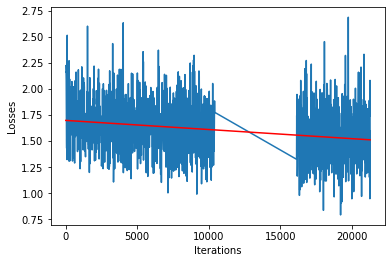

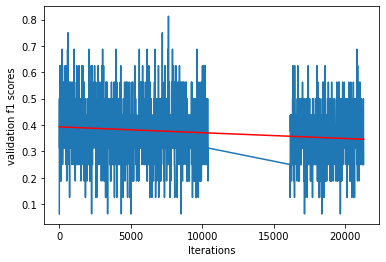

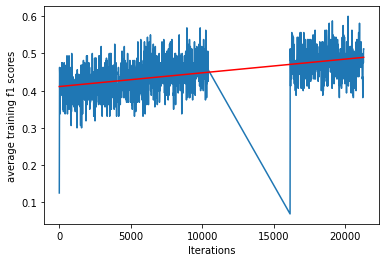

In [0]:
# Plot the training process
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

training_path1 = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/training_process.txt"
training_path2 = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/training_process2.txt"
def read_file(path):
    iterations = []
    losses = []
    validation_f1 = []
    average_training_f1 = []
    with open(path, 'r') as f:
        for line in f.readlines():
            line_list = line.split()
            if len(line_list) < 13:
                continue
            iteration = int(line_list[1].split('/')[0][1:])
            loss = float(line_list[3][:-1])
            valid_f1 = float(line_list[7][:-1])
            ave_train_f1 = float(line_list[-1][:-1])
            # print(iteration, loss, valid_f1, ave_train_f1)

            iterations.append(iteration)
            losses.append(loss)
            validation_f1.append(valid_f1)
            average_training_f1.append(ave_train_f1)

    return iterations, losses, validation_f1, average_training_f1

def plot(x, y, x_label, y_label):
    # plot x and y
    plt.plot(x, y)

    # use linear regression to find a line that best fit the plot
    x = np.array(x)
    y = np.array(y)
    x, y = x.reshape(-1,1), y.reshape(-1,1)

    plt.plot( x, LinearRegression().fit(x, y).predict(x), 'r-' )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

iteration1, loss1, validation1, average_training1 = read_file(training_path1)
iteration2, loss2, validation2, average_training2 = read_file(training_path2)

iterations = iteration1 + iteration2
losses = loss1 + loss2
validation_f1 = validation1 + validation2
average_training_f1 = average_training1 + average_training2

plot(iterations, losses, "Iterations", "Losses")
plot(iterations, validation_f1, "Iterations", "validation f1 scores")
plot(iterations, average_training_f1, "Iterations", "average training f1 scores")

#**3. Run the model on unlabeled dataset**

In [0]:
# load unlabeled dataset
import pandas as pd

path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/mergedComments_2019_02.csv"
unlabelled_discourse_file = pd.read_csv(path)

print(discourse_file.columns)
print(discourse_file[:5])


Index(['post', 'post_type'], dtype='object')
                                                post     post_type
0  ['it', 'was', 'only', 'a', 'few', 'minutes', '...  announcement
1  ['i', 've', 'wanted', 'to', 'watch', 'this', '...   elaboration
2  ['you', 'strike', 'me', 'as', 'the', 'type', '...   elaboration
3  ['yeah', 'i', 've', 'always', 'heard', 'that',...   elaboration
4  ['alright', 'guys', 'little', 'background', 'a...  announcement


In [0]:
# clean up the unlabelled data
import csv

posts = []
clean_unlabel_text = []
for post in unlabelled_discourse_file["mergedText"].apply(str):
    clean_text = clean_posts(post)

    posts.append(post)
    clean_unlabel_text.append(clean_text)


In [0]:
# load the model
model_path = "/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/Model_32hsize_1layer_bidirectional_5epochs_16batch.pt"
hidden_size = 32          # number of features in hidden state of the RNN decoder
num_layers = 1              # number of LSTM layers
num_discourse_type = 10
bidirectional = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM(hidden_dim = hidden_size, 
               discourse_types = num_discourse_type,
               lstm_layers = num_layers, 
               bidirectional = bidirectional,
               device = device)
               
model.load_state_dict(torch.load(model_path))
model.to(device)

batch_size = 32
iterations = int(len(clean_unlabel_text) / batch_size + 0.5) 

unlabelled_predictions = []

for i in range(iterations):
    if i != iterations - 1: 
        X = clean_unlabel_text[i*batch_size:(i+1)*batch_size] 
    else:
        X = clean_unlabel_text[i*batch_size:]
    
    X = posts2vec(X, pre_trained_word2vec_model)
    X = torch.FloatTensor(X).to(device)

    tag_score = model(X, batch_size)
    # calculate f1 score
    prediction = torch.argmax(tag_score, dim=1).cpu().numpy().tolist()
    unlabelled_predictions += prediction
    print('Iterations [%d/%d]' % (len(unlabelled_predictions), len(clean_unlabel_text)))

Iterations [32/199482]
Iterations [64/199482]
Iterations [96/199482]
Iterations [128/199482]
Iterations [160/199482]
Iterations [192/199482]
Iterations [224/199482]
Iterations [256/199482]
Iterations [288/199482]
Iterations [320/199482]
Iterations [352/199482]
Iterations [384/199482]
Iterations [416/199482]
Iterations [448/199482]
Iterations [480/199482]
Iterations [512/199482]
Iterations [544/199482]
Iterations [576/199482]
Iterations [608/199482]
Iterations [640/199482]
Iterations [672/199482]
Iterations [704/199482]
Iterations [736/199482]
Iterations [768/199482]
Iterations [800/199482]
Iterations [832/199482]
Iterations [864/199482]
Iterations [896/199482]
Iterations [928/199482]
Iterations [960/199482]
Iterations [992/199482]
Iterations [1024/199482]
Iterations [1056/199482]
Iterations [1088/199482]
Iterations [1120/199482]
Iterations [1152/199482]
Iterations [1184/199482]
Iterations [1216/199482]
Iterations [1248/199482]
Iterations [1280/199482]
Iterations [1312/199482]
Iteration

In [0]:
# save the unlabeled data discourse type
clean_unlabel_path = '/content/drive/My Drive/GT_classes/CSE_6240 - Text Mining/Reddit-Roles-Identification/discourse/unlabelled_dataset_predictions.csv'
posts_annotations = open(preprocess_file, 'w')
fieldnames = ['original_post', 'clean_post', 'post_type']
writer = csv.DictWriter(posts_annotations, fieldnames=fieldnames)

writer.writeheader()

for i in range(len(clean_unlabel_text)):
    print(clean_text)
    original_post = posts[i]
    clean_text = clean_unlabel_text[i]
    dict_to_store = {'original_post':, 'clean_post':clean_text, "post_type":post_type}
    if clean_text:
    print(dict_to_store)
        writer.writerow(dict_to_store)